# Loading data

In [1]:
from DataPreparation.CryptoPreprocessor import CryptoPreprocessor
from DataPreparation.TweetPreprocessor import TweetPreprocessor
from gensim.test.utils import datapath
from gensim.models import LdaMulticore
import pandas as pd
import numpy as np
import json

 
tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
twt_prep = TweetPreprocessor(tweets_df)
mod_tweets_df = twt_prep.transform()

temp_file = datapath(r"D:\Projects\ElonMuskCrypto\Models\NLPmodels\lda")
lda_model = LdaMulticore.load(temp_file)
id2word = lda_model.id2word
with open('corpus.json', 'r') as r:
    corpus = json.load(r)
btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
crypto_prep = CryptoPreprocessor()

topics_btc = pd.read_csv('new_topics_btc.csv', index_col=0)
topics_btc.index = pd.to_datetime(topics_btc.index)
tweets = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
btc_df = pd.read_csv('Data/btc_data.csv')    
tweets['date'] = pd.to_datetime(tweets['date'])  
btc_df['time'] = pd.to_datetime(btc_df['time'])

# Accessing XGB model

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



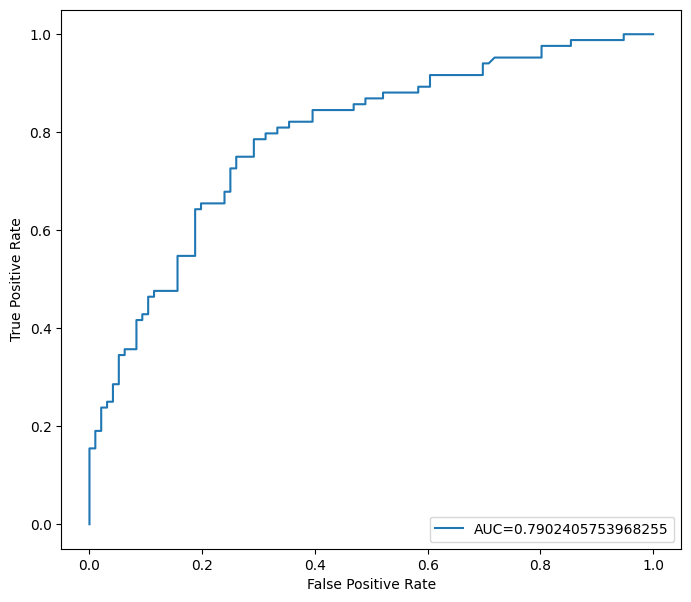

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


data = topics_btc.copy()
horizons = [2,7,21,28,60,90,180,364]
data, new_predictors = crypto_prep.add_trend_season(data, horizons)
best_model = XGBClassifier()
best_model.load_model('Models/CRYPTOmodels/xgbc_bertopic.json')

X_test, y_test = data[best_model.feature_names_in_].iloc[-180:], data['target'].iloc[-180:]
y_pred_proba = best_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)


def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.figure(figsize=(8,7))
    plt.plot(fpr, tpr, label=f'AUC={auc}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    
plot_roc_curve(y_test, y_pred_proba)


# Hypothesis testing

## Comparing two types of models
***
by randomly training 15000 candidates for data including tweets and data excluding tweets
i ensure that:
1.  the results are robuts to any coincidence
2.  not tuned for certain type of data (one or another) 
and selected from the same parameter space (even though very vast)
***

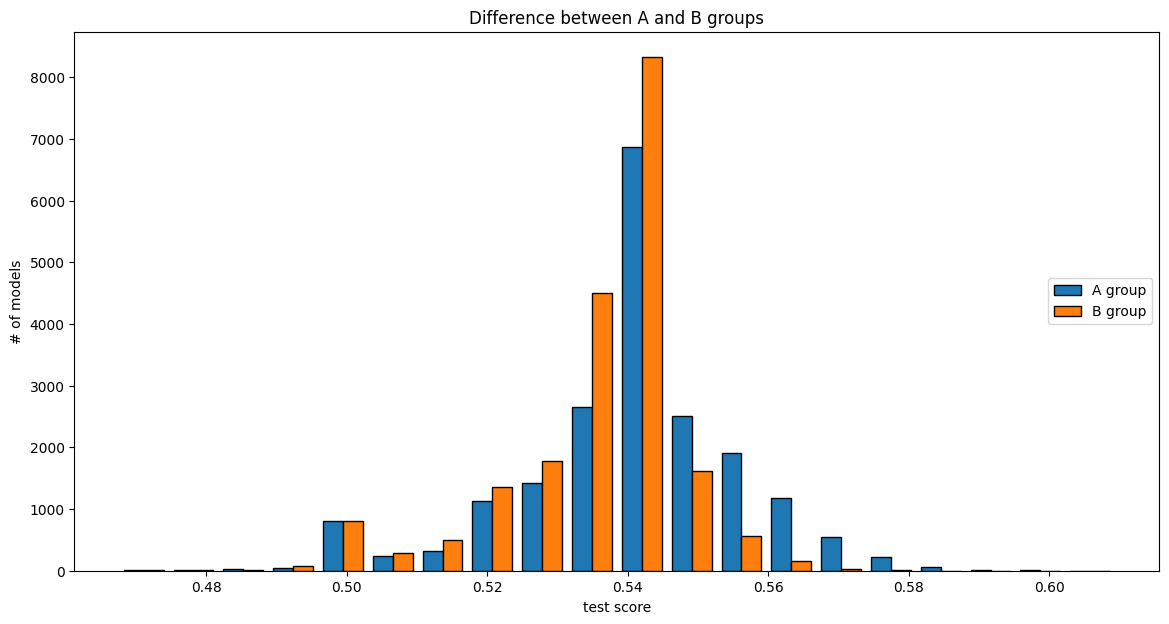

In [23]:
def plot_groups(tuner_A, tuner_B, bins=10):
    scores_A = tuner_A['mean_test_score'].copy()
    scores_B = tuner_B['mean_test_score'].copy()
    
    fig, ax1 = plt.subplots()
    fig.set_figwidth(14)
    fig.set_figheight(7)
    
    n,b,_ = ax1.hist([scores_A, scores_B], 
                    ec='k', 
                    label=['A group','B group'], 
                    bins=bins, 
                    range=(np.min([scores_A, scores_B])-0.001,
                           np.max([scores_A, scores_B])+0.001))
    ax1.legend(loc='right')
    ax1.set(title='Difference between A and B groups', xlabel='test score', ylabel='# of models')           
    
    return n,b


A_group = pd.concat([pd.read_csv('Models/Tuned_in_csv/with_tweets_models (1).csv', index_col=0), 
                     pd.read_csv('Models/Tuned_in_csv/with_tweets_models.csv', index_col=0)])

B_group = pd.concat([pd.read_csv('Models/Tuned_in_csv/without_tweets_models (1).csv', index_col=0), 
                     pd.read_csv('Models/Tuned_in_csv/without_tweets_models.csv', index_col=0)])

df = pd.concat([A_group['mean_test_score'], B_group['mean_test_score']], axis=1, verify_integrity=True)
df.columns = ['with_tweets_scores','without_tweets_scores']

n,bins  = plot_groups(A_group, B_group, 20)

In [24]:
from sklearn.metrics import balanced_accuracy_score


best_model = XGBClassifier()
best_model.load_model(f'Models/CRYPTOmodels/xgbc_bertopic.json')
balanced_accuracy_score(y_test, best_model.predict(X_test))

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Projects\ElonMuskCrypto\venv\lib\site-packages\xgboost\data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



0.7321428571428572

In [4]:
from dash import Dash, dcc, html
from dash.dependencies import Output, Input
import plotly.express as px


MIN,MAX = 10,25
app = Dash(__name__)
app.layout = html.Div([dcc.Graph(id='histogram'),
                       html.P("Bins:"),
                       dcc.Slider(id='bins-slider',min=MIN, max=MAX,step=1, value=8)                                 
                       ])

@app.callback(Output('histogram', 'figure'),
              [Input('bins-slider', 'value')])
def update_histogram(bins):
    fig = px.histogram(df, 
                       nbins=bins, 
                    #    barmode="stack",
                       labels={'value':'mean test score'},
                       title=f'bins = {bins}',
                       width=950,
                       height=500)
    
    fig.update_traces(marker_line_color='black',
                      marker_line_width=0.5)
    return fig


app.run(debug=True)

#### From histograms we can conclude that to have a significant increase in accuracy we most certainly have to use data with tweets due to dominance among scores past 0.56.

In [5]:
from scipy import stats


alpha = 0.05
tstat, pvalue = stats.wilcoxon(df['with_tweets_scores'], df['without_tweets_scores'])
pvalue, pvalue < alpha

(0.0, True)

In [6]:
tstat, pvalue = stats.ttest_ind(df['with_tweets_scores'], df['without_tweets_scores'], equal_var=False)
pvalue, pvalue < alpha

(3.7800271535095065e-291, True)

#### Based on statistical tests(Wilcoxon and T-test) i can conclude that there is some kind of relationship between Elon Musk's tweets and changes in Bitcoin with alpha = 0.05 and p-values very close to zero that most likely eliminates randomness considering sizes of samples being large enough to represent a wide set of parameters.

In [7]:
param_grid = {'n_estimators':np.arange(5,30,1),
              'max_depth':np.arange(2,10,1),
              'gamma':np.linspace(0, 5, 10),
              'alpha':np.arange(1,50,10),
              'lambda':np.arange(1,50,10),
              'learning_rate':np.arange(0.01, 0.5, 0.01),
              'max_delta_step':np.linspace(0,1,10),
              'grow_policy':['depthwise', 'lossguide']
              }